# Dataset download

In [1]:
# !pip install kaggle

In [2]:
#!kaggle datasets download -d mrdaniilak/russia-real-estate-20182021
#!unzip russia-real-estate-20182021.zip

# The code

## Part 1. Data preparing

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### Step 0. Useful functions

In [4]:
def describe_df(df):

    results = []
    for col in df.columns:
        missing_percentage = (df[col].isnull().sum() / len(df)) * 100
        try:  # Обработка ошибок для нечисловых столбцов
            min_val = df[col].min()
            p1 = np.nanpercentile(df[col], 1)
            p5 = np.nanpercentile(df[col], 5)
            median = df[col].median()
            mean = df[col].mean()
            p95 = np.nanpercentile(df[col], 95)
            p99 = np.nanpercentile(df[col], 99)
            max_val = df[col].max()
        except TypeError:
            min_val = np.nan
            p1 = np.nan
            p5 = np.nan
            median = np.nan
            mean = np.nan
            p95 = np.nan
            p99 = np.nan
            max_val = np.nan

        results.append([missing_percentage, min_val, p1, p5, median, mean, p95, p99, max_val])

    result_df = pd.DataFrame(results, columns=['% пропусков', 'Минимум', '1% перцентиль', '5% перцентиль', 'Медиана', 'Среднее', '95% перцентиль', '99% перцентиль', 'Максимум'], index=df.columns)
    return result_df


def feature_interaction_correlation(df, target_column):
    """
    Строит матрицу корреляций взаимодействий признаков с целевым признаком.

    Args:
        df: pandas DataFrame с данными.
        target_column: Название столбца с целевым признаком.

    Returns:
        pandas DataFrame: Матрица корреляций.
        matplotlib.axes._subplots.AxesSubplot: Тепловая карта матрицы.
    """


    numerical_features = df.select_dtypes(include=np.number).columns  # Выбираем только числовые признаки
    n_features = len(numerical_features)
    interaction_correlations = pd.DataFrame(np.zeros((n_features, n_features)), index=numerical_features, columns=numerical_features)


    for i in range(n_features):
        for j in range(n_features):
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]

            if feature1 == target_column or feature2 == target_column:  # Пропускаем взаимодействие с самим целевым признаком
                continue


            interaction_feature = df[feature1] * df[feature2] #Создаём новый признак-произведение
            correlation = np.corrcoef(interaction_feature, df[target_column])[0, 1]  # Расчитываем корреляцию
            interaction_correlations.loc[feature1, feature2] = correlation


    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(interaction_correlations, annot=True, cmap='coolwarm', fmt=".2f", center = 0)
    plt.title(f'Корреляция взаимодействия признаков с {target_column}')

    return interaction_correlations, ax

### Step 1. First look

In [5]:
df = pd.read_csv("all_v2.csv")

| Feature | Description | Data Type |
|---|---|---|
| `date` | Date of publication | Date |
| `time` | Time of publication | Time |
| `geo_lat` | Latitude | Numerical (float) |
| `geo_lon` | Longitude | Numerical (float) |
| `region` | Region of Russia | Categorical |
| `building_type` | Building type | Categorical |
| `object_type` | Object type (new building / other) | Categorical |
| `level` | Floor number of the apartment | Numerical (integer) |
| `levels` | Number of floors in the building | Numerical (integer) |
| `rooms` | Number of rooms | Numerical (integer) |
| `area` | Total area of the apartment | Numerical (float) |
| `kitchen_area` | Kitchen area | Numerical (float) |
| `price` | Price of the apartment (in rubles) | Numerical (integer) |

![Frequency distributions of column values]("stats.jpg")

In [6]:
description = describe_df(df)
print(description)

               % пропусков       Минимум  1% перцентиль  5% перцентиль  \
price                  0.0 -2.144967e+09  750000.000000   1.150000e+06   
date                   0.0           NaN            NaN            NaN   
time                   0.0           NaN            NaN            NaN   
geo_lat                0.0  4.145906e+01      43.430700   4.489504e+01   
geo_lon                0.0  1.989020e+01      29.851724   3.031855e+01   
region                 0.0  3.000000e+00       3.000000   3.000000e+00   
building_type          0.0  0.000000e+00       0.000000   0.000000e+00   
level                  0.0  1.000000e+00       1.000000   1.000000e+00   
levels                 0.0  1.000000e+00       2.000000   3.000000e+00   
rooms                  0.0 -2.000000e+00      -1.000000  -1.000000e+00   
area                   0.0  7.000000e-02      19.800000   2.900000e+01   
kitchen_area           0.0  1.000000e-02       2.000000   5.000000e+00   
object_type            0.0  1.000000e+

### Step 2. Corrections

In [7]:
df.dropna()
df = df.drop(['time', 'region'], axis=1)

In [8]:
df = df[(df['rooms'] >= -1)]
df = df[(df['rooms'] != 0)]

In [9]:
price_p5 = np.percentile(df['price'], 5) # not too small as minus two billions
price_p95 = np.percentile(df['price'], 95) #not too large as plus two billions
df = df[(df['price'] >= price_p5) & (df['price'] <= price_p95)]
df = df[(df['area'] >= 10)]
df = df[(df['kitchen_area'] < df['area'])]

In [10]:
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

df = df.drop(["date"], axis=1)

### Step 3. Statistical analysis

In [11]:
description = describe_df(df)
print(description)

               % пропусков       Минимум  1% перцентиль  5% перцентиль  \
price                  0.0  1.150000e+06   1.190000e+06   1.350000e+06   
geo_lat                0.0  4.145906e+01   4.342965e+01   4.489190e+01   
geo_lon                0.0  1.989020e+01   2.977690e+01   3.032645e+01   
building_type          0.0  0.000000e+00   0.000000e+00   0.000000e+00   
level                  0.0  1.000000e+00   1.000000e+00   1.000000e+00   
levels                 0.0  1.000000e+00   2.000000e+00   4.000000e+00   
rooms                  0.0 -1.000000e+00  -1.000000e+00  -1.000000e+00   
area                   0.0  1.000000e+01   2.080000e+01   2.990000e+01   
kitchen_area           0.0  1.000000e-02   2.700000e+00   5.000000e+00   
object_type            0.0  1.000000e+00   1.000000e+00   1.000000e+00   
year                   0.0  2.018000e+03   2.018000e+03   2.018000e+03   
month                  0.0  1.000000e+00   1.000000e+00   1.000000e+00   

                    Медиана       Сре

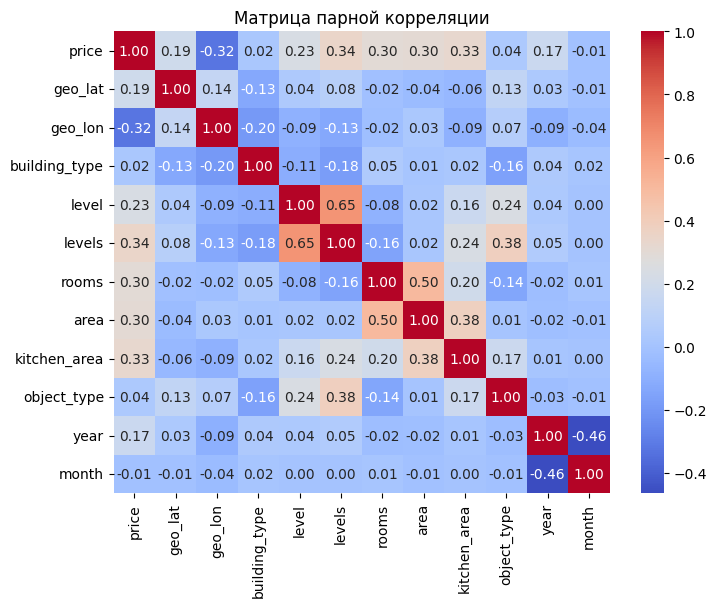

In [12]:
correlation_matrix = df.corr()

plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f") 
plt.title('Матрица парной корреляции')
plt.show()


Theoretically we should remove features "month", "building_type", "object_type". But in fact experiments show that this information helps reduce model inaccuracy by 3%.

(               price   geo_lat   geo_lon  building_type     level    levels  \
 price            0.0  0.000000  0.000000       0.000000  0.000000  0.000000   
 geo_lat          0.0  0.199224 -0.285097       0.058500  0.255456  0.370348   
 geo_lon          0.0 -0.285097 -0.290160      -0.128663  0.049309  0.073914   
 building_type    0.0  0.058500 -0.128663       0.002854  0.196965  0.261662   
 level            0.0  0.255456  0.049309       0.196965  0.223490  0.277484   
 levels           0.0  0.370348  0.073914       0.261662  0.277484  0.335762   
 rooms            0.0  0.321279  0.083658       0.217273  0.374432  0.481888   
 area             0.0  0.341818  0.050060       0.221870  0.354108  0.465499   
 kitchen_area     0.0  0.360881  0.055981       0.222231  0.337525  0.430371   
 object_type      0.0  0.054730 -0.111996       0.072615  0.131484  0.152814   
 year             0.0  0.192848 -0.324181       0.022580  0.234503  0.344344   
 month            0.0  0.018963 -0.19546

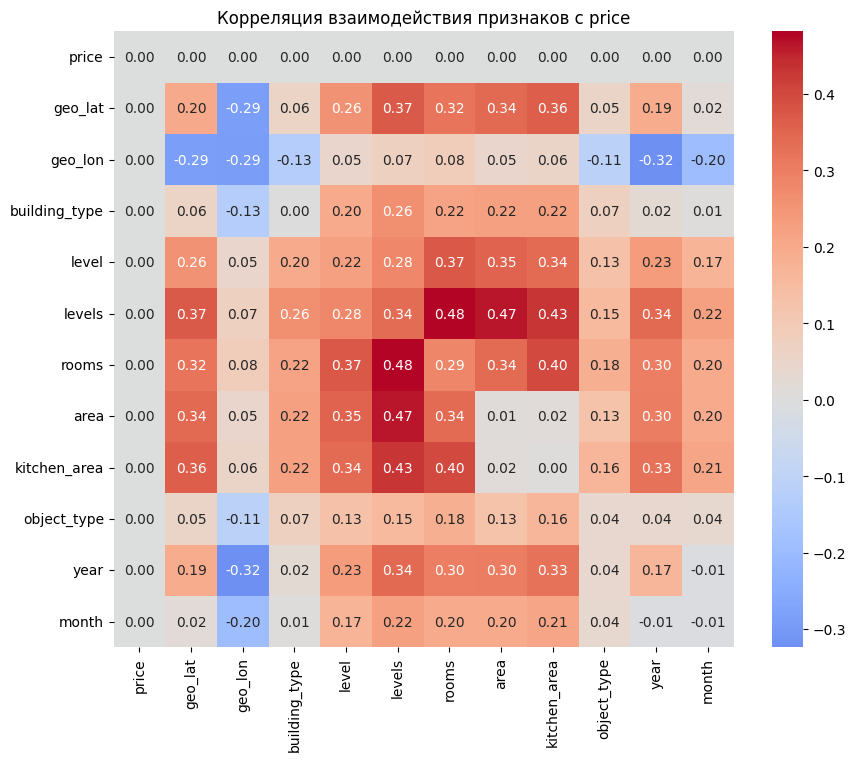

In [13]:
feature_interaction_correlation(df, "price")

In [14]:
df["levels_rooms"] = df["levels"] * df["rooms"]
df["levels_area"] = df["levels"] * df["area"]

In [15]:
inflation_dct = {
    (2018, 1): 1,
    (2018, 2): 1.0031,
    (2018, 3): 1.00520651,
    (2018, 4): 1.008121608879,
    (2018, 5): 1.01195247099274,
    (2018, 6): 1.0157978903825124,
    (2018, 7): 1.0207753000453867,
    (2018, 8): 1.0235313933555092,
    (2018, 9): 1.0236337464948448,
    (2018, 10): 1.0252715604892366,
    (2018, 11): 1.028860010950949,
    (2018, 12): 1.0340043110057036,
    (2018, 13): 1.0426899472181514,
    (2019, 2): 1.0532211156850548,
    (2019, 3): 1.057855288594069,
    (2019, 4): 1.0612404255175703,
    (2019, 5): 1.0643180227515712,
    (2019, 6): 1.0679367040289265,
    (2019, 7): 1.068363878710538,
    (2019, 8): 1.0705006064679592,
    (2019, 9): 1.0679314050124362,
    (2019, 10): 1.0662227147644163,
    (2019, 11): 1.06760880429361,
    (2019, 12): 1.070598108945632,
    (2019, 13): 1.0744522621378363,
    (2020, 2): 1.0787500711863875,
    (2020, 3): 1.0823099464213026,
    (2020, 4): 1.0882626511266198,
    (2020, 5): 1.0972952311309707,
    (2020, 6): 1.1002579282550242,
    (2020, 7): 1.1026784956971853,
    (2020, 8): 1.1065378704321256,
    (2020, 9): 1.1060952552839527,
    (2020, 10): 1.105320988605254,
    (2020, 11): 1.1100738688562566,
    (2020, 12): 1.117955393325136,
    (2020, 13): 1.1272344230897346,
    (2021, 2): 1.1347868937244359,
    (2021, 3): 1.1436382314954865,
    (2021, 4): 1.1511862438233567,
    (2021, 5): 1.157863124037532,
    (2021, 6): 1.1664313111554099,
    (2021, 7): 1.1744796872023822,
    (2021, 8): 1.1781205742327097,
    (2021, 9): 1.1801233792089052,
    (2021, 10): 1.1872041194841587,
    (2021, 11): 1.200382085210433,
    (2021, 12): 1.2119057532284532,
    (2021, 13): 1.2218433804049265,
}


In [16]:
df["price"] = df["price"] / df.apply(
    lambda row: inflation_dct.get((row["year"], row["month"]), 1), axis=1
)

In [17]:
df.to_parquet("all_v2.parquet")
del df
df = pd.read_parquet("all_v2.parquet")

## Part 2. Models learning

In [18]:
import pickle
from catboost import CatBoostRegressor, Pool
from joblib import dump, load
from scipy.optimize import minimize
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split

### Step 0. Useful functions

In [19]:
def optimize_correlation(df, target_column="price"):
    """Находит линейную комбинацию признаков, которая максимально коррелирует с заданным целевым признаком."""
    features = df.drop(columns=target_column).columns
    X = df[features].values
    P = df[target_column].values
    n = len(features)

    cov_matrix = np.cov(X, rowvar=False)
    cov_XP = np.cov(X, P, rowvar=False)[:n, n:].flatten()

    def target_function(a_rest):
        weights = np.insert(a_rest, 0, 1.0)
        L = weights @ cov_XP
        S = weights @ cov_matrix @ weights
        return -np.abs(L) / np.sqrt(S)  # Минимизируем -|L|/sqrt(S)

    initial_guess = np.zeros(n - 1)
    result = minimize(target_function, initial_guess)
    weights = np.insert(result.x, 0, 1.0)

    linear_combination = X @ weights
    correlation = np.corrcoef(linear_combination, P)[0, 1]

    return correlation, weights


def results_metrics(predictions, target_test):
    me = (predictions - target_test).mean()
    rmse = root_mean_squared_error(target_test, predictions)
    mae = mean_absolute_error(target_test, predictions)
    r2 = r2_score(target_test, predictions)
    rmse_relative = rmse / target_test.mean()
    mae_relative = mae / target_test.mean()
    mape = np.mean(np.abs((predictions - target_test) / target_test))
    smape = np.mean(np.abs(predictions - target_test)) / np.mean(predictions + target_test)
    results_test = {
        "me": me,
        "rmse": rmse,
        "rmse_relative": rmse_relative,
        "mae": mae,
        "mae_relative": mae_relative,
        "mape": mape,
        "smape": smape,
        "r2": r2,
    }
    return results_test

def visualize_predictions(predictions, y_test):
    """
    Визуализирует предсказания модели, строя графики распределения ошибки, 
    процентной ошибки и диаграмму рассеяния (y_test, predictions).

    Args:
        predictions (array-like): Вектор предсказаний модели.
        y_test (array-like): Вектор истинных значений.
    """

    if len(predictions) != len(y_test):
        raise ValueError("Размеры векторов predictions и y_test должны совпадать.")
        
    error = predictions - y_test

    lower_bound = np.percentile(error, 1)
    upper_bound = np.percentile(error, 99)

    # Создаем маску для отбора значений внутри интервала
    mask = (error >= lower_bound) & (error <= upper_bound)

    # Фильтруем predictions и y_test
    error = error[mask]
    predictions = predictions[mask]
    y_test = y_test[mask]
    
    plt.figure(figsize=(10, 6))
    sns.histplot(error, kde=True, bins=30, stat="probability")
    plt.title('Распределение ошибки')
    plt.xlabel('Ошибка')
    plt.show()

    # 2. Распределение процентной ошибки
    percentage_error = error / y_test * 100 
    plt.figure(figsize=(10, 6))
    sns.histplot(percentage_error, kde=True, bins=30, stat="probability")
    plt.title('Распределение процентной ошибки')
    plt.xlabel('Процентная ошибка, %')
    plt.show()

    # 3. Диаграмма рассеяния (y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=predictions)
    plt.title('Диаграмма рассеяния (y_test, predictions)')
    plt.xlabel('Истинные значения (y_test)')
    plt.ylabel('Предсказанные значения (predictions)')
    # Добавляем линию y=x для наглядности
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
    plt.show()

### Step 1. Data splitting

In [20]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

target_train = df_train["price"]
features_train = df_train.drop(["price"], axis=1)

target_test = df_test["price"]
features_test = df_test.drop(["price"], axis=1)

### Step 2. Clustering

In [21]:
N_CLUSTERS = 10

cluster_method = KMeans(n_clusters=N_CLUSTERS, random_state=42)
cluster_method.fit(features_train)

df_train["cluster"] = cluster_method.predict(features_train)
df_test["cluster"] = cluster_method.predict(features_test)
df_train["optimal_combination"] = 0.1
df_test["optimal_combination"] = 0.1

cluster_correlations = []
for cluster in range(N_CLUSTERS):
    cluster_data_train = df_train[df_train["cluster"] == cluster].copy()
    cluster_data_test = df_test[df_test["cluster"] == cluster].copy()

    correlation, weights = optimize_correlation(
        cluster_data_train, target_column="price"
    )
    cluster_correlations.append(correlation)

    X_train = cluster_data_train.drop(columns=["price"]).values
    df_train.loc[df_train["cluster"] == cluster, "optimal_combination"] = (
        X_train @ weights
    )

    X_test = cluster_data_test.drop(columns=["price"]).values
    df_test.loc[df_test["cluster"] == cluster, "optimal_combination"] = X_test @ weights

cluster_prices = (
    df_train.groupby("cluster")["price"].sum()
    / df_train.groupby("cluster")["optimal_combination"].sum()
)

df_train["ppc_price"] = df_train["optimal_combination"] * df_train.apply(
    lambda row: cluster_prices[row["cluster"]], axis=1
)

df_test["ppc_price"] = df_test["optimal_combination"] * df_test.apply(
    lambda row: cluster_prices[row["cluster"]], axis=1
)

X_train = df_train.drop(["price", "cluster"], axis=1)
y_train = target_train

X_test = df_test.drop(["price",  "cluster"], axis=1)
y_test = target_test


### Step 3. RandomForest learning

In [22]:
N_ESTIMATORS = 10

random_forest_model = RandomForestRegressor(
    n_estimators=N_ESTIMATORS,
    criterion="friedman_mse",
    # criterion="squared_error",
    random_state=42,
    # max_depth=40,
    max_features=1.0,
    n_jobs=-1,
    # min_samples_split=4,
    # min_samples_leaf=4,
    bootstrap=True,
    verbose=0,
)
random_forest_model.fit(X_train, y_train)
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(random_forest_model, file)
print(random_forest_model.get_params())

random_forest_predictions = random_forest_model.predict(X_test)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


{'me': 3810.2234721331247, 'rmse': 517852.4709215137, 'rmse_relative': 0.15389370906619462, 'mae': 279744.68383098807, 'mae_relative': 0.08313361314988402, 'mape': 0.08704831812497213, 'smape': 0.04154328663986056, 'r2': 0.9318125908316103}


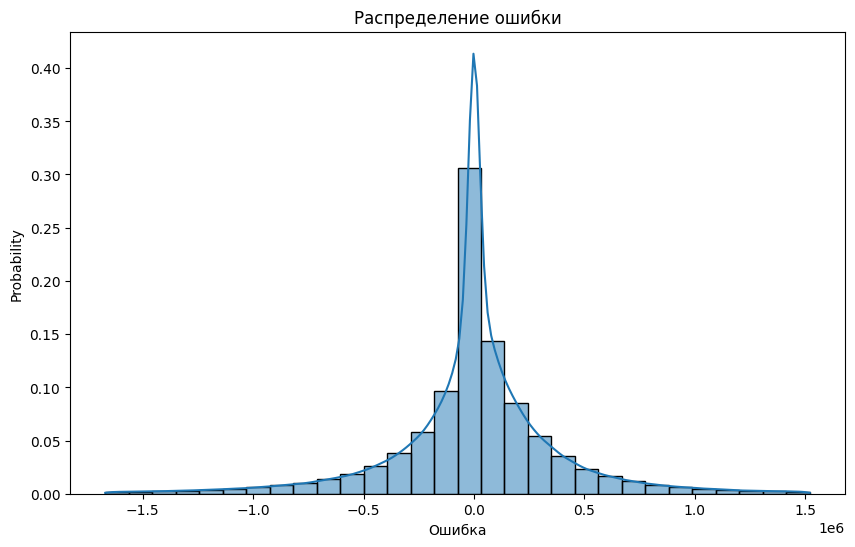

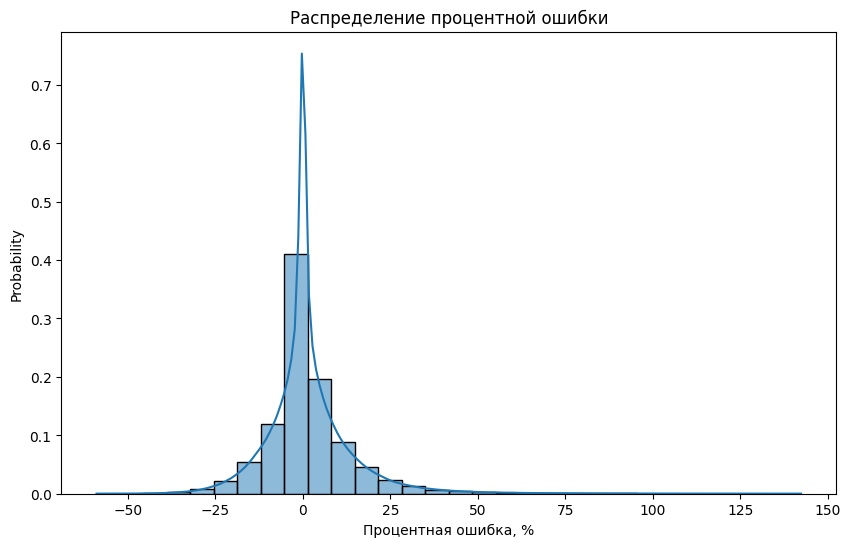

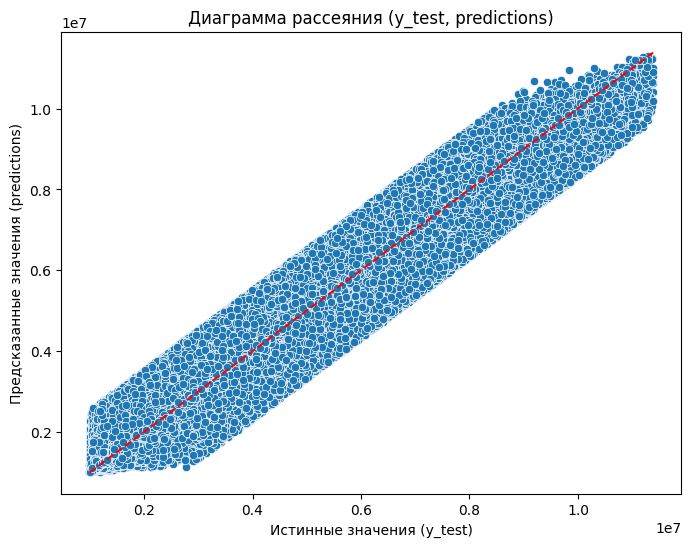

In [23]:
random_forest_results = results_metrics(random_forest_predictions, y_test)
print(random_forest_results)
visualize_predictions(random_forest_predictions, y_test)

### Step 3. CatBoost learning

In [24]:
cat_features = ["building_type", "object_type"]

train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [25]:
catboost_model = CatBoostRegressor(
    iterations=1000, 
    learning_rate=0.5,
    depth=10, 
    l2_leaf_reg=3,
    loss_function="RMSE", 
    eval_metric="MAE", 
    early_stopping_rounds=100, 
    random_seed=42,
    verbose=0,
    task_type="GPU", 
)

catboost_model.fit(    
    train_pool, eval_set=test_pool, plot=True
)
with open('catboost_model.pkl', 'wb') as file:
    pickle.dump(catboost_model, file)

catboost_predictions = catboost_model.predict(test_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because MAE is/are not implemented for GPU


{'me': 174.25104373636609, 'rmse': 684038.1786522728, 'rmse_relative': 0.2032802359103492, 'mae': 446869.2826919718, 'mae_relative': 0.13279915659925529, 'mape': 0.14351463206609652, 'smape': 0.06639785914760205, 'r2': 0.8810258069966881}


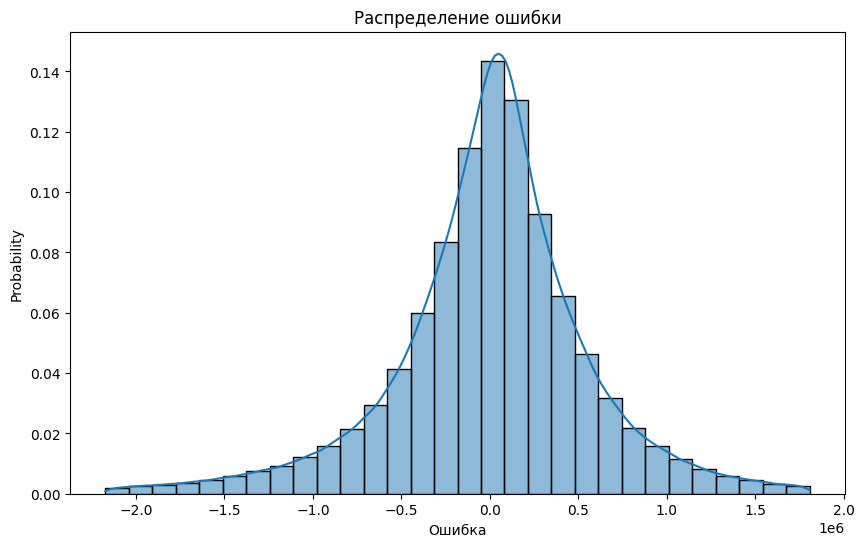

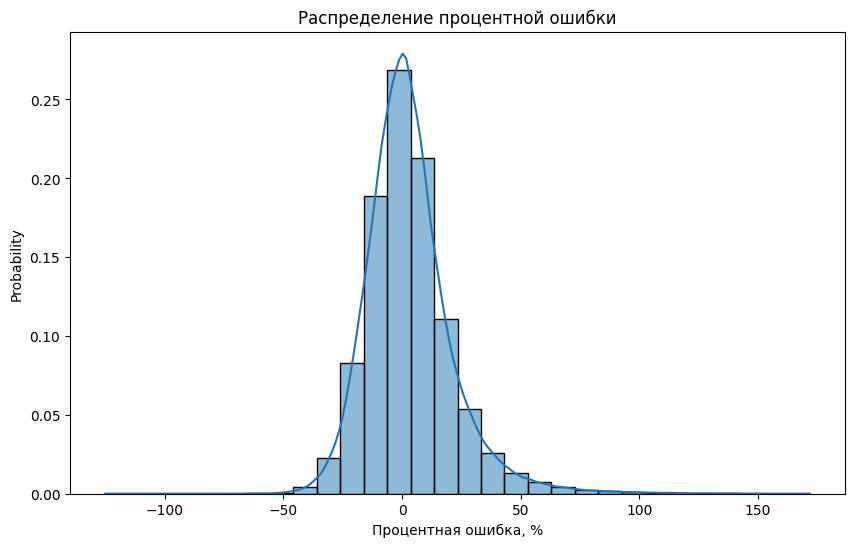

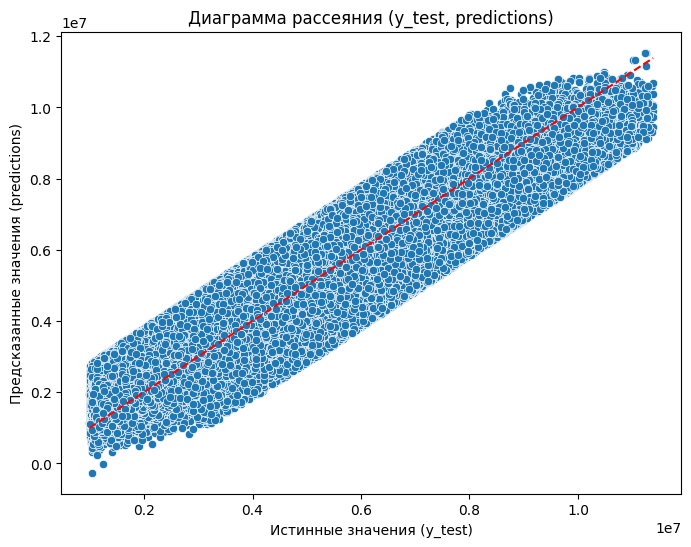

In [26]:
catboost_results=results_metrics(catboost_predictions, target_test)
print(catboost_results)
visualize_predictions(catboost_predictions, y_test)

### Step 4. NeuralNetwork learning

In [27]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2024-12-21 11:13:30.010234: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-21 11:13:30.117929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734768810.157764    6962 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734768810.169058    6962 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-21 11:13:30.268711: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [28]:
df_train_neural = pd.DataFrame()
df_test_neural = pd.DataFrame()

le_building_type = LabelEncoder()
df_train_neural["building_type"] = le_building_type.fit_transform(df_train["building_type"])
df_test_neural["building_type"] = le_building_type.transform(df_test["building_type"])

le_object_type = LabelEncoder()
df_train_neural["object_type"] = le_object_type.fit_transform(df_train["object_type"])
df_test_neural["object_type"] = le_object_type.transform(df_test["object_type"])

numerical_features = list(df_train.columns)
numerical_features.remove("price")
numerical_features.remove("object_type")
numerical_features.remove("building_type")
scaler = StandardScaler()
df_train_neural[numerical_features] = scaler.fit_transform(df_train[numerical_features])
df_test_neural[numerical_features] = scaler.transform(df_test[numerical_features])

df_train_neural["price"] = df_train["price"]
df_test_neural["price"] = df_test["price"]
X_train_neural = df_train_neural.drop(["price", "cluster"], axis=1)
y_train_neural = target_train

X_test_neural = df_test_neural.drop(["price",  "cluster"], axis=1)
y_test_neural = target_test

In [35]:
neural_network_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1),  # Линейная активация для регрессии
    ]
)

neural_network_model.compile(optimizer="adam", loss="mse", metrics=["mae"])


history = neural_network_model.fit(
    X_train_neural,
    y_train_neural,
    epochs=50,
    batch_size=1024,
    validation_data=(X_test, y_test),
)

with open('neural_network_model.pkl', 'wb') as file:
    pickle.dump(neural_network_model, file)
    
# neural_network_model = tf.keras.models.load_model('neural_network_model.keras')

neural_network_predictions = neural_network_model.predict(X_test_neural).flatten()

/home/maxwell/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 8008832122880.0000 - mae: 2125641.0000 - val_loss: 2301280466474400430948352.0000 - val_mae: 1452376326144.0000
Epoch 2/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2410321281024.0000 - mae: 1063524.5000 - val_loss: 5484098262198875190198272.0000 - val_mae: 2242425913344.0000
Epoch 3/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2100101513216.0000 - mae: 997392.4375 - val_loss: 8961612738448837270568960.0000 - val_mae: 2866610438144.0000
Epoch 4/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2040388648960.0000 - mae: 978324.2500 - val_loss: 9803899143304947645284352.0000 - val_mae: 2998291398656.0000
Epoch 5/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1970255822848.0000 - mae: 971224.7500 - val_loss: 10148865939619866935820288.0000 - val_mae: 3050582310912.0000
Epoch 6/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1938332319744.0000 - mae: 969761.1250 - val_loss: 10402674691330036656

{'me': -11449.922891156535, 'rmse': 1093651.4670104058, 'rmse_relative': 0.32500777757112415, 'mae': 755181.2960836119, 'mae_relative': 0.22442231561609607, 'mape': 0.24644293866198594, 'smape': 0.11240239084820731, 'r2': 0.6958765115057852}


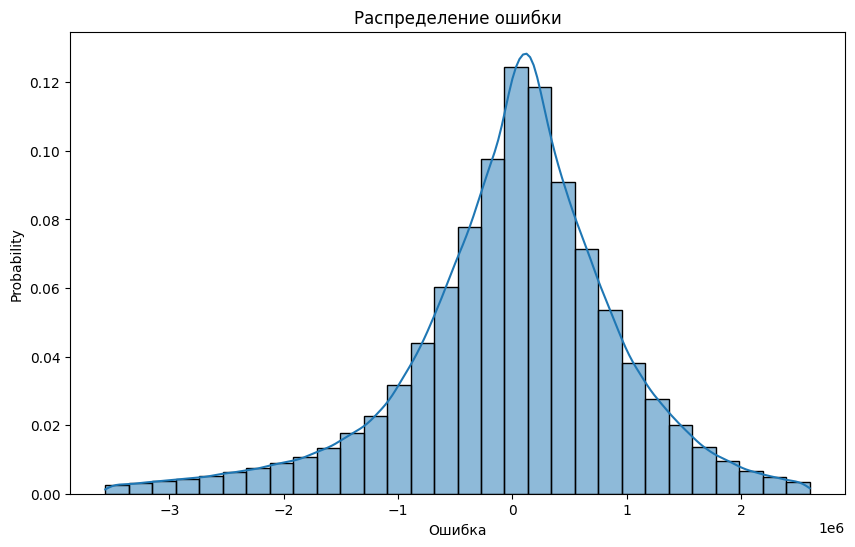

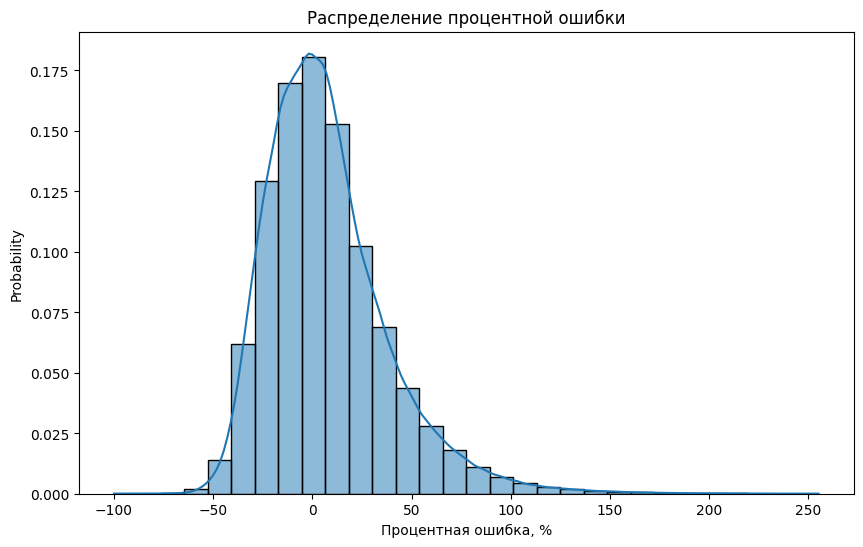

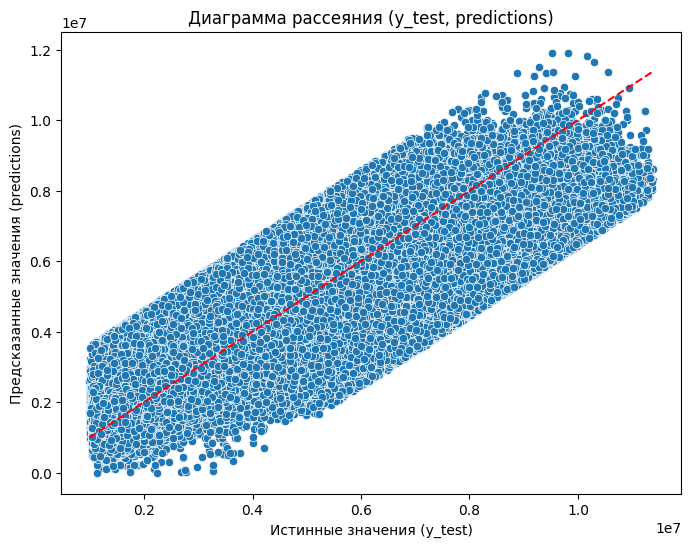

In [36]:
neural_network_results=results_metrics(neural_network_predictions, y_test)
print(neural_network_results)
visualize_predictions(neural_network_predictions, y_test)

## Part 3. Comparison of models

In [37]:
total_results = {
    "Random Forest": random_forest_results,
    "Catboost": catboost_results,
    "Neural network": neural_network_results}

results_df = pd.DataFrame()

for model_name, results in total_results.items():
    results_df[model_name] = pd.Series(results)

results_df = results_df.T

print(results_df)

                          me          rmse  rmse_relative            mae  \
Random Forest    3810.223472  5.178525e+05       0.153894  279744.683831   
Catboost          174.251044  6.840382e+05       0.203280  446869.282692   
Neural network -11449.922891  1.093651e+06       0.325008  755181.296084   

                mae_relative      mape     smape        r2  
Random Forest       0.083134  0.087048  0.041543  0.931813  
Catboost            0.132799  0.143515  0.066398  0.881026  
Neural network      0.224422  0.246443  0.112402  0.695877  


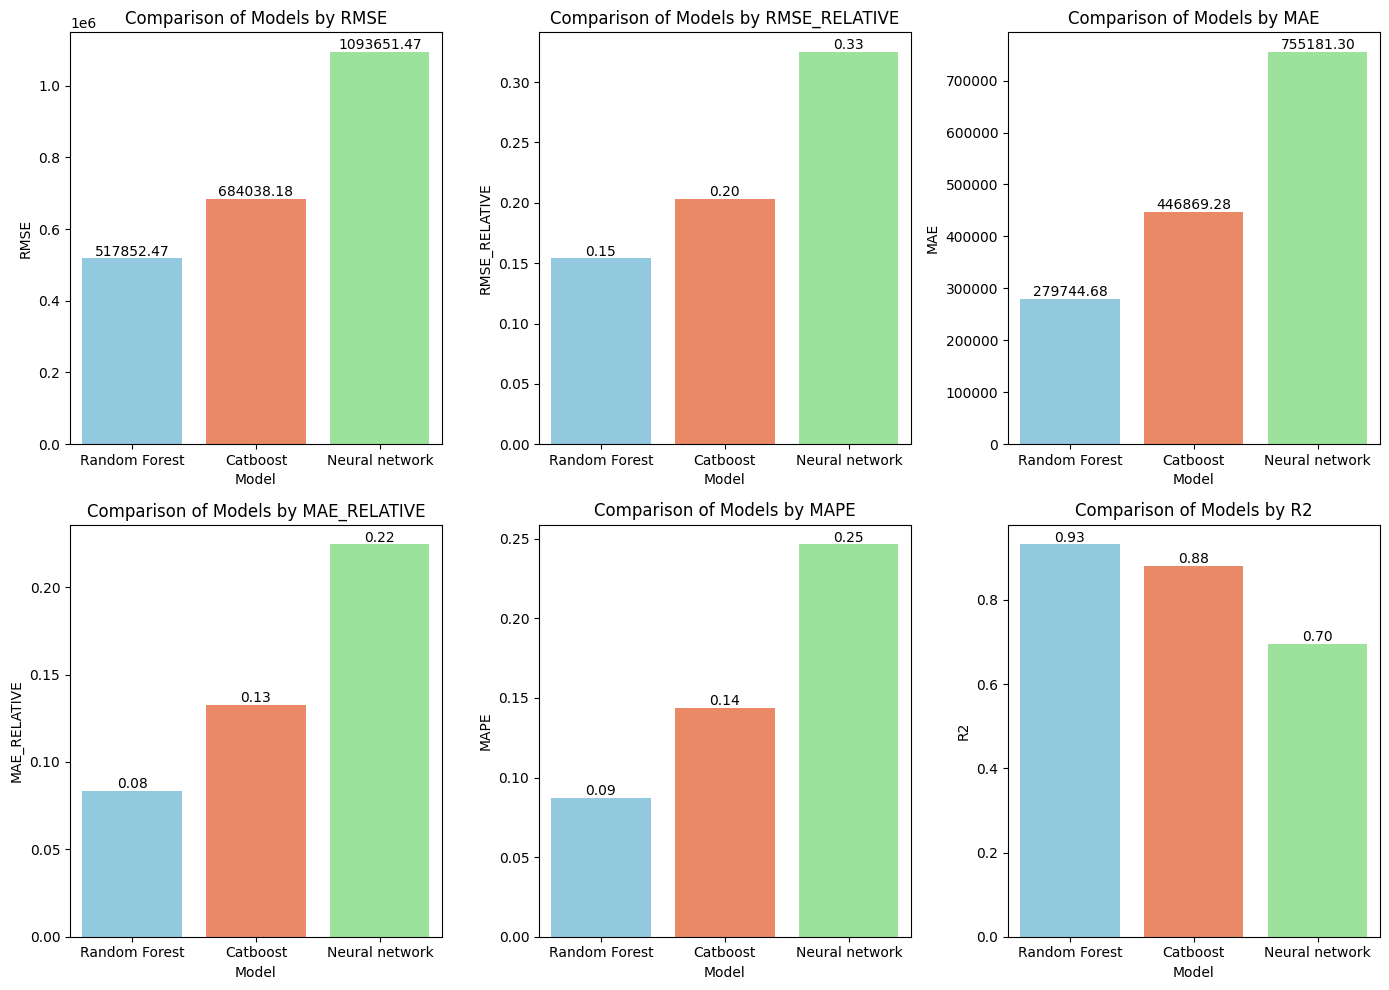

In [41]:
metrics = ['rmse', 'rmse_relative', 'mae', 'mae_relative', 'mape', 'r2']
models = results_df.index
colors = ['skyblue', 'coral', 'lightgreen']

model_color_map = dict(zip(models, colors))

fig, axes = plt.subplots(2, 3, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(x=results_df.index, y=results_df[metric], hue=results_df.index, 
                palette=model_color_map, dodge=False, legend=False, ax=ax)
    ax.set_title(f'Comparison of Models by {metric.upper()}')
    ax.set_ylabel(metric.upper())
    ax.set_xlabel('Model')

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')


plt.tight_layout()
plt.show()

In [103]:
import random
random_index = random.randint(0, len(X_test) - 1)
rand_row = X_test.iloc[random_index].copy()
rand_row_price = y_test.iloc[random_index]
print("Prices of object:")
print("Real price                 ", rand_row_price)
print("Random Forest price        ", random_forest_predictions[random_index])
print("Catboost price             ", catboost_predictions[random_index])
print("Neural Network price       ", neural_network_predictions[random_index])
print("-----------------")
print("Parameters of object:")
print(rand_row)

Prices of object:
Real price                  4682126.831274981
Random Forest price         5024252.359229093
Catboost price              5159547.228302002
Neural Network price        5145745.5
-----------------
Parameters of object:
geo_lat                6.008289e+01
geo_lon                3.035214e+01
building_type          2.000000e+00
level                  2.300000e+01
levels                 2.500000e+01
rooms                  1.000000e+00
area                   3.900000e+01
kitchen_area           1.420000e+01
object_type            1.000000e+00
year                   2.021000e+03
month                  4.000000e+00
levels_rooms           2.500000e+01
levels_area            9.750000e+02
optimal_combination    3.083191e+03
ppc_price              4.215396e+06
Name: 5302584, dtype: float64
